# NB01: Respiratory Chain Condition Map

**Project**: Condition-Specific Respiratory Chain Wiring in ADP1

**Goal**: Extract all respiratory chain components from the ADP1 genome, build a condition × component heatmap showing which are essential on which carbon sources, and identify substrate-specific respiratory configurations.

**Inputs**: `user_data/berdl_tables.db`

**Outputs**:
- `data/respiratory_chain_genes.csv` — all respiratory chain genes with growth data
- Condition × component heatmap
- Condition-specificity analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sqlite3
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'
DB_PATH = '../user_data/berdl_tables.db'

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '') for c in GROWTH_COLS]

# Verify tables available
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(f'Available tables: {tables["name"].tolist()}')
conn.close()

Available tables: ['genome', 'genome_ani', 'genome_features', 'missing_functions', 'pan_genome_features', 'gene_reaction_data', 'genome_reactions', 'growth_phenotype_summary', 'growth_phenotypes_detailed', 'gene_phenotypes', 'ontology_terms', 'ontology_definitions', 'ontology_relationships', 'gene_essentiality', 'strains']


## 1. Extract All Respiratory Chain Components

Search by RAST function keywords AND KO/EC identifiers to avoid missing components (per plan reviewer recommendation).

In [2]:
conn = sqlite3.connect(DB_PATH)

# Broad search for respiratory chain genes
resp = pd.read_sql_query(f"""
    SELECT feature_id, old_locus_tag, gene_names, rast_function, ko, ec, pfam,
           essentiality_minimal, start, end, strand,
           {', '.join(GROWTH_COLS)}
    FROM genome_features
    WHERE rast_function LIKE '%NADH%dehydrogenase%'
       OR rast_function LIKE '%NADH%ubiquinone%'
       OR rast_function LIKE '%NADH%oxidoreductase%'
       OR rast_function LIKE '%NADH%FMN%'
       OR rast_function LIKE '%NADH%flavin%'
       OR rast_function LIKE '%cytochrome%oxidase%'
       OR rast_function LIKE '%ubiquinol oxidase%'
       OR rast_function LIKE '%Cytochrome O %'
       OR rast_function LIKE '%Cytochrome d %'
       OR rast_function LIKE '%Cytochrome bd%'
       OR rast_function LIKE '%Cytochrome bo%'
       OR rast_function LIKE '%terminal oxidase%'
       OR rast_function LIKE '%cbb3%'
       OR rast_function LIKE '%ATP synthase%'
       OR rast_function LIKE '%F0F1%'
       OR rast_function LIKE '%succinate dehydrogenase%'
       OR rast_function LIKE '%fumarate reductase%'
       OR rast_function LIKE '%quinone%reductase%'
       OR ko IN ('K03885', 'K03923')  -- NDH-2, NQO1
       OR ko LIKE 'K003%'  -- Complex I KOs
    ORDER BY start
""", conn)

conn.close()

print(f'Total respiratory chain candidates: {len(resp)}')

Total respiratory chain candidates: 62


In [3]:
# Classify into respiratory chain subsystems
def classify_respiratory(row):
    func = str(row['rast_function']) if pd.notna(row['rast_function']) else ''
    ko = str(row['ko']) if pd.notna(row['ko']) else ''
    
    if ('NADH' in func and ('ubiquinone' in func or 'oxidoreductase chain' in func)) or \
       any(f'K003{i}' in ko for i in range(30, 44)):  # K00330-K00343
        return 'Complex I (NDH-1)'
    elif 'K03885' in ko or ('NADH dehydrogenase' in func and 'chain' not in func.lower() 
                            and 'subunit' not in func.lower()):
        return 'NDH-2'
    elif 'NADH' in func and ('FMN' in func or 'flavin' in func):
        return 'NADH-flavin OR'
    elif 'Cytochrome O' in func or 'Cytochrome o' in func or \
         ('ubiquinol oxidase' in func.lower() and ('cyoA' in str(row.get('gene_names','')) or 
          'ACIAD242' in str(row.get('old_locus_tag','')))):
        return 'Cyt bo3 oxidase'
    elif 'Cytochrome d' in func or 'Cytochrome bd' in func:
        return 'Cyt bd oxidase'
    elif 'cbb3' in func.lower():
        return 'Cyt cbb3 oxidase'
    elif 'ATP synthase' in func or 'F0F1' in func:
        return 'ATP synthase'
    elif 'succinate dehydrogenase' in func.lower() or 'fumarate reductase' in func.lower():
        return 'Complex II (SDH)'
    else:
        return 'Other respiratory'

resp['subsystem'] = resp.apply(classify_respiratory, axis=1)

print('=== Respiratory Chain Subsystems ===')
print(resp['subsystem'].value_counts().to_string())
print()

# Show all genes by subsystem
for sub in ['Complex I (NDH-1)', 'NDH-2', 'NADH-flavin OR', 'Cyt bo3 oxidase', 
            'Cyt bd oxidase', 'Complex II (SDH)', 'ATP synthase', 'Other respiratory']:
    genes = resp[resp['subsystem'] == sub]
    if len(genes) > 0:
        print(f'\n{sub} ({len(genes)} genes):')
        for _, row in genes.iterrows():
            locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
            gene = row['gene_names'] if pd.notna(row['gene_names']) else ''
            func = str(row['rast_function'])[:55] if pd.notna(row['rast_function']) else '?'
            has_data = 'YES' if pd.notna(row['mutant_growth_quinate']) else ' NO'
            print(f'  {locus:15s} {gene:8s} data={has_data}  {func}')

=== Respiratory Chain Subsystems ===
subsystem
Other respiratory    20
Complex I (NDH-1)    13
ATP synthase          9
NADH-flavin OR        5
Cyt bd oxidase        5
Complex II (SDH)      5
Cyt bo3 oxidase       4
NDH-2                 1


Complex I (NDH-1) (13 genes):
  ACIAD0730       ndhC     data=YES  NADH ubiquinone oxidoreductase chain A (EC 1.6.5.3)
  ACIAD0731       nuoB     data=YES  NADH-ubiquinone oxidoreductase chain B (EC 1.6.5.3)
  ACIAD_RS03350   nuoC     data= NO  NADH-ubiquinone oxidoreductase chain C (EC 1.6.5.3);NAD
  ACIAD0734       nuoE     data=YES  NADH-ubiquinone oxidoreductase chain E (EC 1.6.5.3)
  ACIAD0735       nuoF     data=YES  NADH-ubiquinone oxidoreductase chain F (EC 1.6.5.3)
  ACIAD0736       nuoG     data=YES  NADH-ubiquinone oxidoreductase chain G (EC 1.6.5.3)
  ACIAD0737       nuoH     data=YES  NADH-ubiquinone oxidoreductase chain H (EC 1.6.5.3)
  ACIAD0738       nuoI     data=YES  NADH-ubiquinone oxidoreductase chain I (EC 1.6.5.3)
  ACIAD0739  

## 2. Growth Heatmap: Respiratory Chain × Carbon Source

In [4]:
# Filter to genes WITH growth data
resp_with_data = resp[resp[GROWTH_COLS].notna().any(axis=1)].copy()
print(f'Respiratory genes with growth data: {len(resp_with_data)} / {len(resp)}')
print(f'Missing growth data: {len(resp) - len(resp_with_data)} genes')

# List genes without data
no_data = resp[resp[GROWTH_COLS].isna().all(axis=1)]
print(f'\nGenes without growth data:')
for _, row in no_data.iterrows():
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    print(f'  {locus:15s} [{row["subsystem"]:20s}] {str(row["rast_function"])[:50]}')

Respiratory genes with growth data: 36 / 62
Missing growth data: 26 genes

Genes without growth data:
  ACIAD_RS00830   [ATP synthase        ] ATP synthase protein I
  ACIAD_RS00835   [ATP synthase        ] ATP synthase F0 sector subunit a (EC 3.6.3.14)
  ACIAD_RS00840   [ATP synthase        ] ATP synthase F0 sector subunit c (EC 3.6.3.14)
  ACIAD_RS00845   [ATP synthase        ] ATP synthase F0 sector subunit b (EC 3.6.3.14)
  ACIAD_RS00850   [ATP synthase        ] ATP synthase delta chain (EC 3.6.3.14)
  ACIAD_RS00855   [ATP synthase        ] ATP synthase alpha chain (EC 3.6.3.14)
  ACIAD_RS00860   [ATP synthase        ] ATP synthase gamma chain (EC 3.6.3.14)
  ACIAD_RS00865   [ATP synthase        ] ATP synthase beta chain (EC 3.6.3.14)
  ACIAD_RS00870   [ATP synthase        ] ATP synthase epsilon chain (EC 3.6.3.14)
  ACIAD_RS03350   [Complex I (NDH-1)   ] NADH-ubiquinone oxidoreductase chain C (EC 1.6.5.3
  ACIAD_RS03390   [Complex I (NDH-1)   ] NADH-ubiquinone oxidoreductase chain

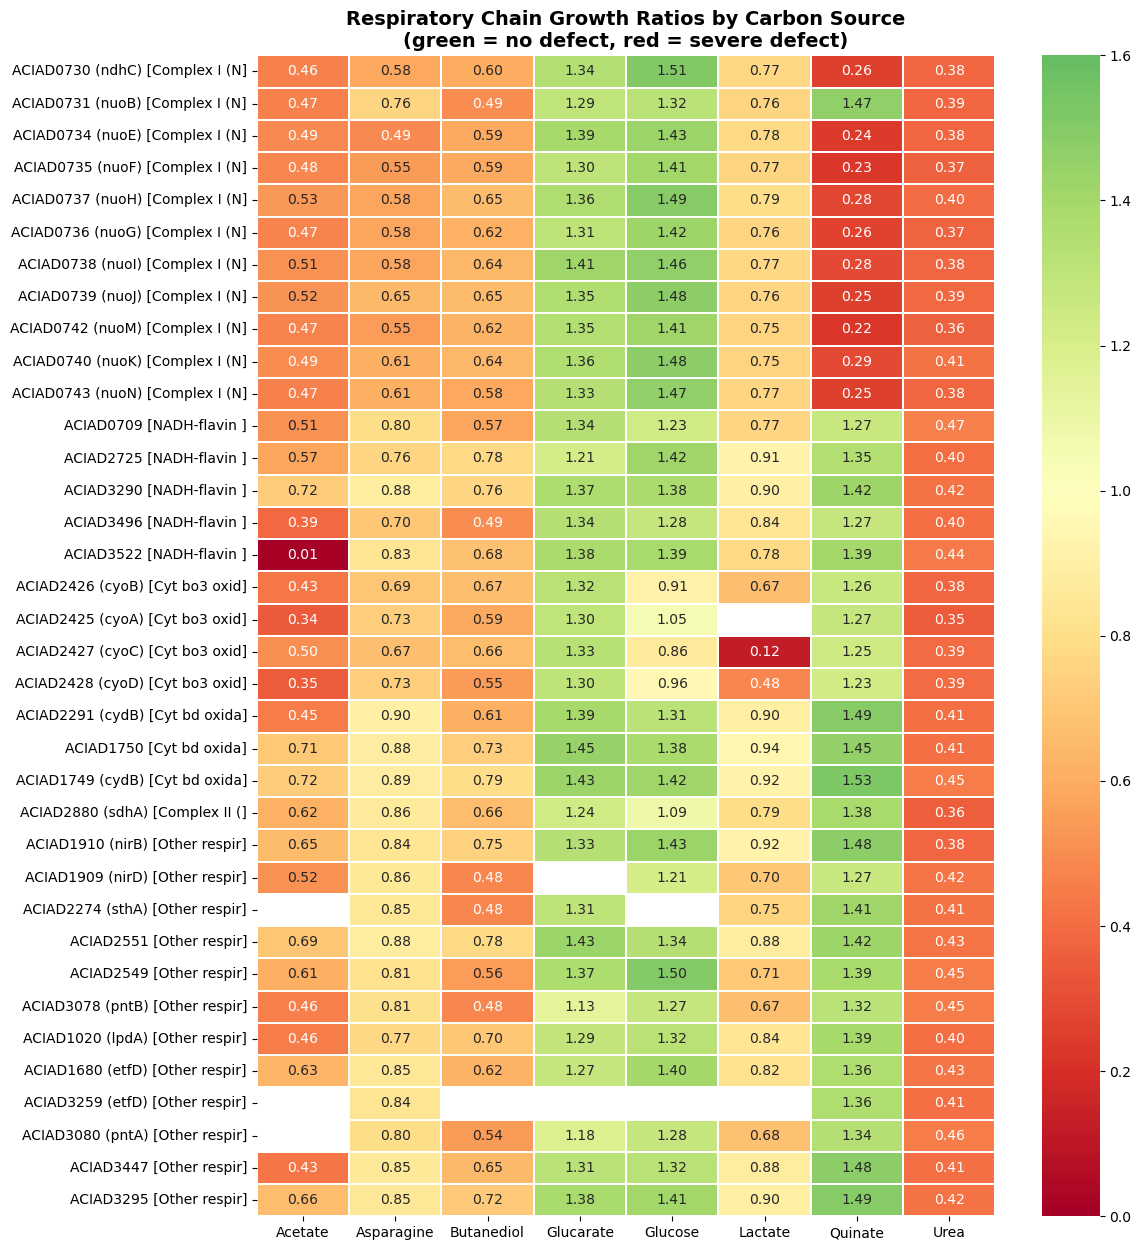

Saved: figures/respiratory_chain_heatmap.png


In [5]:
# Build heatmap: raw growth ratios
# Create row labels
row_labels = []
for _, row in resp_with_data.iterrows():
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    gene = f" ({row['gene_names']})" if pd.notna(row['gene_names']) else ''
    row_labels.append(f'{locus}{gene} [{row["subsystem"][:12]}]')

heatmap_data = resp_with_data[GROWTH_COLS].copy()
heatmap_data.columns = [c.capitalize() for c in CONDITION_NAMES]
heatmap_data.index = row_labels

# Sort by subsystem
subsystem_order = ['Complex I (NDH-1)', 'NADH-flavin OR', 'Cyt bo3 oxidase', 
                   'Cyt bd oxidase', 'Complex II (SDH)', 'ATP synthase', 'Other respiratory']
sort_key = resp_with_data['subsystem'].map({s: i for i, s in enumerate(subsystem_order)}).values
sort_idx = np.argsort(sort_key)
heatmap_sorted = heatmap_data.iloc[sort_idx]

fig, ax = plt.subplots(figsize=(12, max(8, len(heatmap_sorted) * 0.35)))
sns.heatmap(heatmap_sorted, cmap='RdYlGn', center=1.0, vmin=0, vmax=1.6,
            annot=True, fmt='.2f', ax=ax, linewidths=0.3,
            yticklabels=True, xticklabels=True)
ax.set_title('Respiratory Chain Growth Ratios by Carbon Source\n'
             '(green = no defect, red = severe defect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'respiratory_chain_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/respiratory_chain_heatmap.png')

## 3. Condition-Specificity of Respiratory Components

For each respiratory subsystem, compute the mean growth ratio per condition. This reveals which subsystems are condition-specific.

In [6]:
# Mean growth per subsystem × condition
subsystem_profiles = resp_with_data.groupby('subsystem')[GROWTH_COLS].mean()
subsystem_profiles.columns = [c.capitalize() for c in CONDITION_NAMES]

# Also compute the number of genes per subsystem
subsystem_sizes = resp_with_data['subsystem'].value_counts()

print('=== Mean Growth Ratio by Subsystem × Condition ===')
print(subsystem_profiles.round(3).to_string())
print()
print('Genes per subsystem:', dict(subsystem_sizes))

=== Mean Growth Ratio by Subsystem × Condition ===
                   Acetate  Asparagine  Butanediol  Glucarate  Glucose  Lactate  Quinate   Urea
subsystem                                                                                      
Complex I (NDH-1)    0.487       0.595       0.608      1.346    1.444    0.767    0.367  0.384
Complex II (SDH)     0.617       0.862       0.657      1.236    1.091    0.792    1.382  0.360
Cyt bd oxidase       0.625       0.891       0.711      1.424    1.370    0.920    1.490  0.422
Cyt bo3 oxidase      0.407       0.705       0.616      1.311    0.945    0.424    1.253  0.379
NADH-flavin OR       0.442       0.793       0.658      1.326    1.338    0.841    1.341  0.426
Other respiratory    0.567       0.833       0.614      1.302    1.349    0.794    1.392  0.423

Genes per subsystem: {'Other respiratory': np.int64(12), 'Complex I (NDH-1)': np.int64(11), 'NADH-flavin OR': np.int64(5), 'Cyt bo3 oxidase': np.int64(4), 'Cyt bd oxidase': np.int6

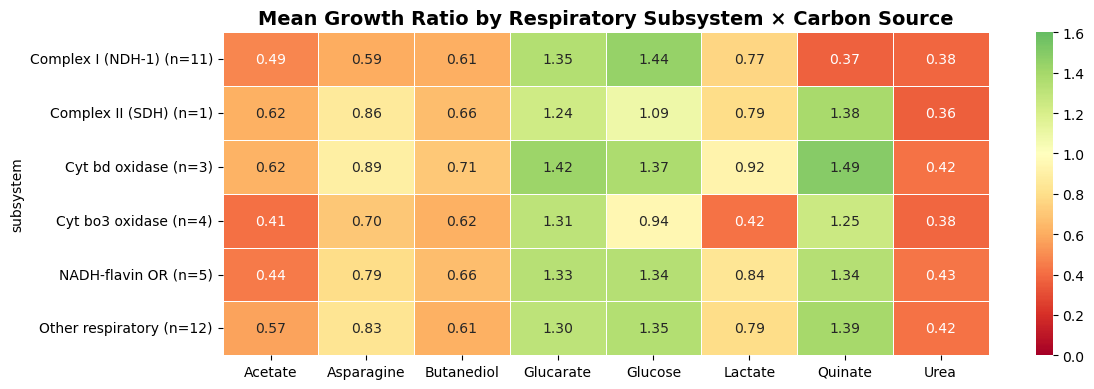

Saved: figures/subsystem_profiles.png


In [7]:
# Subsystem profile heatmap
profile_labels = [f'{sub} (n={subsystem_sizes.get(sub, 0)})' for sub in subsystem_profiles.index]

fig, ax = plt.subplots(figsize=(12, max(4, len(subsystem_profiles) * 0.6)))
sns.heatmap(subsystem_profiles, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
            vmin=0, vmax=1.6, ax=ax, yticklabels=profile_labels, linewidths=0.5)
ax.set_title('Mean Growth Ratio by Respiratory Subsystem × Carbon Source',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'subsystem_profiles.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/subsystem_profiles.png')

In [8]:
# Identify the condition-specific pattern for each subsystem
print('=== Respiratory Chain Wiring Summary ===')
print()

for sub in subsystem_profiles.index:
    profile = subsystem_profiles.loc[sub]
    defect_conditions = profile[profile < 0.8].index.tolist()
    fine_conditions = profile[profile > 1.0].index.tolist()
    
    print(f'{sub} (n={subsystem_sizes.get(sub, 0)}):')
    if defect_conditions:
        defect_str = ', '.join([f'{c} ({profile[c]:.2f})' for c in defect_conditions])
        print(f'  DEFECT on: {defect_str}')
    if fine_conditions:
        fine_str = ', '.join([f'{c} ({profile[c]:.2f})' for c in fine_conditions])
        print(f'  Fine on:   {fine_str}')
    if not defect_conditions:
        print(f'  No defect on any condition (dispensable for respiration?)')
    print()

=== Respiratory Chain Wiring Summary ===

Complex I (NDH-1) (n=11):
  DEFECT on: Acetate (0.49), Asparagine (0.59), Butanediol (0.61), Lactate (0.77), Quinate (0.37), Urea (0.38)
  Fine on:   Glucarate (1.35), Glucose (1.44)

Complex II (SDH) (n=1):
  DEFECT on: Acetate (0.62), Butanediol (0.66), Lactate (0.79), Urea (0.36)
  Fine on:   Glucarate (1.24), Glucose (1.09), Quinate (1.38)

Cyt bd oxidase (n=3):
  DEFECT on: Acetate (0.62), Butanediol (0.71), Urea (0.42)
  Fine on:   Glucarate (1.42), Glucose (1.37), Quinate (1.49)

Cyt bo3 oxidase (n=4):
  DEFECT on: Acetate (0.41), Asparagine (0.70), Butanediol (0.62), Lactate (0.42), Urea (0.38)
  Fine on:   Glucarate (1.31), Quinate (1.25)

NADH-flavin OR (n=5):
  DEFECT on: Acetate (0.44), Asparagine (0.79), Butanediol (0.66), Urea (0.43)
  Fine on:   Glucarate (1.33), Glucose (1.34), Quinate (1.34)

Other respiratory (n=12):
  DEFECT on: Acetate (0.57), Butanediol (0.61), Lactate (0.79), Urea (0.42)
  Fine on:   Glucarate (1.30), Gluc

## 4. Clustering Respiratory Genes by Condition Profile

Do respiratory genes cluster by subsystem when grouped by their condition-dependent growth profiles?

Respiratory genes with complete 8-condition data: 31


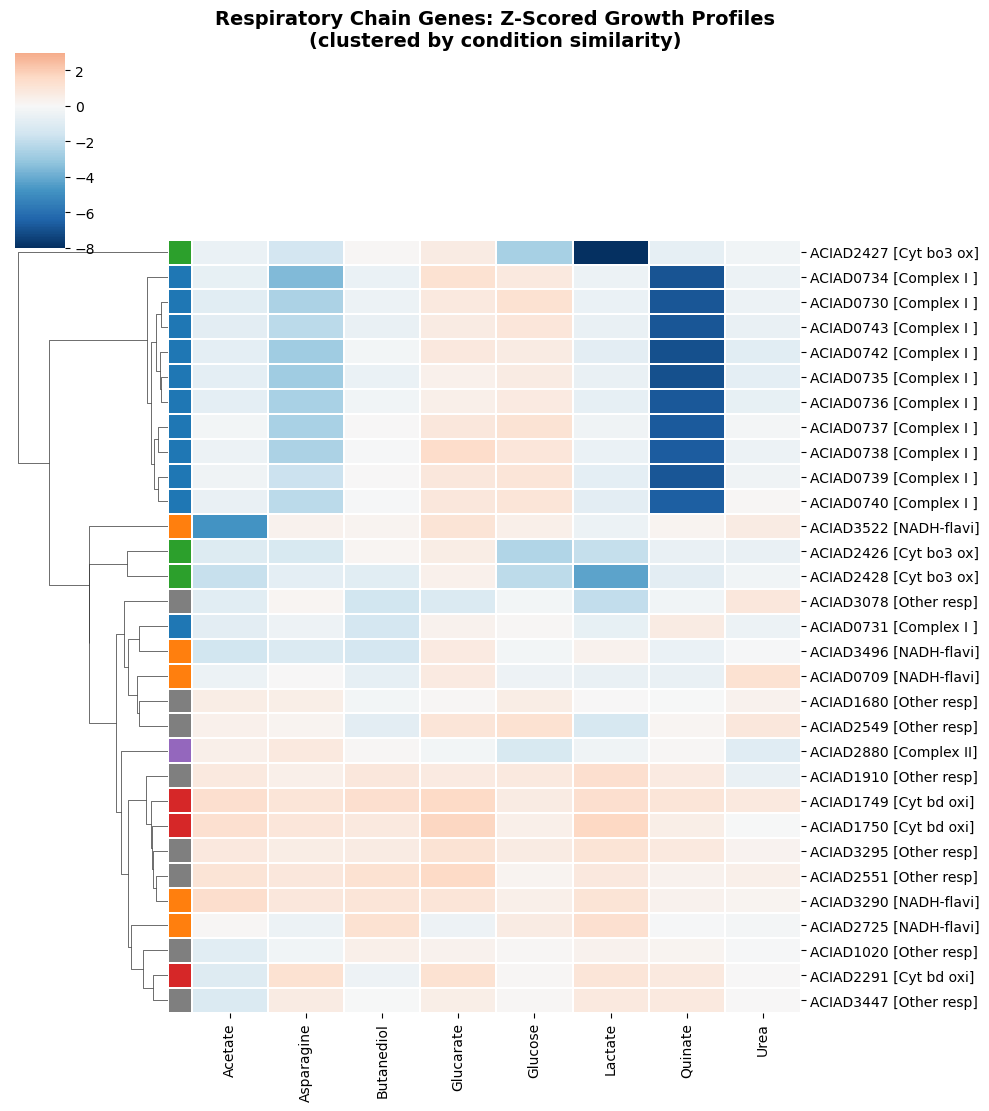

Saved: figures/respiratory_clustermap.png


In [9]:
# Z-score profiles for respiratory genes with complete data
complete_resp = resp_with_data[resp_with_data[GROWTH_COLS].notna().all(axis=1)].copy()
print(f'Respiratory genes with complete 8-condition data: {len(complete_resp)}')

if len(complete_resp) >= 5:
    # Z-score using population-level stats
    conn = sqlite3.connect(DB_PATH)
    pop = pd.read_sql_query(f"""
        SELECT {', '.join(GROWTH_COLS)} FROM genome_features
        WHERE {' AND '.join(f'{c} IS NOT NULL' for c in GROWTH_COLS)}
    """, conn)
    conn.close()
    
    scaler = StandardScaler()
    scaler.fit(pop[GROWTH_COLS])
    
    z_data = pd.DataFrame(
        scaler.transform(complete_resp[GROWTH_COLS]),
        index=complete_resp.index,
        columns=[c.capitalize() for c in CONDITION_NAMES]
    )
    
    # Row labels with subsystem
    z_labels = []
    row_colors = []
    color_map = {
        'Complex I (NDH-1)': '#1f77b4',
        'NADH-flavin OR': '#ff7f0e',
        'Cyt bo3 oxidase': '#2ca02c',
        'Cyt bd oxidase': '#d62728',
        'Complex II (SDH)': '#9467bd',
        'ATP synthase': '#8c564b',
        'Other respiratory': '#7f7f7f'
    }
    for idx in complete_resp.index:
        row = complete_resp.loc[idx]
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
        z_labels.append(f'{locus} [{row["subsystem"][:10]}]')
        row_colors.append(color_map.get(row['subsystem'], '#7f7f7f'))
    
    z_data.index = z_labels
    
    g = sns.clustermap(z_data, cmap='RdBu_r', center=0, vmin=-8, vmax=3,
                       figsize=(10, max(8, len(z_data) * 0.35)),
                       row_cluster=True, col_cluster=False,
                       row_colors=row_colors,
                       linewidths=0.3, yticklabels=True)
    g.fig.suptitle('Respiratory Chain Genes: Z-Scored Growth Profiles\n'
                   '(clustered by condition similarity)',
                   fontsize=14, fontweight='bold', y=1.02)
    plt.savefig(os.path.join(FIG_DIR, 'respiratory_clustermap.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: figures/respiratory_clustermap.png')
else:
    print('Too few genes with complete data for clustering')

## 5. Respiratory Chain Wiring Model

In [10]:
# Build a summary wiring model
# For each carbon source, which respiratory components are essential?

wiring = {}
for cond, col in zip(CONDITION_NAMES, GROWTH_COLS):
    essential = []
    dispensable = []
    for sub in subsystem_profiles.index:
        mean_growth = subsystem_profiles.loc[sub, cond.capitalize()]
        if mean_growth < 0.6:
            essential.append(sub)
        elif mean_growth > 1.0:
            dispensable.append(sub)
    wiring[cond] = {'essential': essential, 'dispensable': dispensable}

print('=== Carbon Source → Respiratory Configuration ===')
print()
for cond in CONDITION_NAMES:
    ess = wiring[cond]['essential']
    disp = wiring[cond]['dispensable']
    print(f'{cond.upper():15s}')
    if ess:
        print(f'  Required:    {" + ".join(ess)}')
    else:
        print(f'  Required:    (none specifically required)')
    if disp:
        print(f'  Dispensable: {" + ".join(disp)}')
    print()

=== Carbon Source → Respiratory Configuration ===

ACETATE        
  Required:    Complex I (NDH-1) + Cyt bo3 oxidase + NADH-flavin OR + Other respiratory

ASPARAGINE     
  Required:    Complex I (NDH-1)

BUTANEDIOL     
  Required:    (none specifically required)

GLUCARATE      
  Required:    (none specifically required)
  Dispensable: Complex I (NDH-1) + Complex II (SDH) + Cyt bd oxidase + Cyt bo3 oxidase + NADH-flavin OR + Other respiratory

GLUCOSE        
  Required:    (none specifically required)
  Dispensable: Complex I (NDH-1) + Complex II (SDH) + Cyt bd oxidase + NADH-flavin OR + Other respiratory

LACTATE        
  Required:    Cyt bo3 oxidase

QUINATE        
  Required:    Complex I (NDH-1)
  Dispensable: Complex II (SDH) + Cyt bd oxidase + Cyt bo3 oxidase + NADH-flavin OR + Other respiratory

UREA           
  Required:    Complex I (NDH-1) + Complex II (SDH) + Cyt bd oxidase + Cyt bo3 oxidase + NADH-flavin OR + Other respiratory



In [11]:
# Save respiratory chain data
resp.to_csv(os.path.join(DATA_DIR, 'respiratory_chain_genes.csv'), index=False)
print(f'Saved: data/respiratory_chain_genes.csv ({len(resp)} genes)')

# Save subsystem profiles
subsystem_profiles.to_csv(os.path.join(DATA_DIR, 'subsystem_profiles.csv'))
print(f'Saved: data/subsystem_profiles.csv')

print(f'\n=== NB01 Summary ===')
print(f'Total respiratory chain genes: {len(resp)}')
print(f'With growth data: {len(resp_with_data)}')
print(f'Without growth data: {len(resp) - len(resp_with_data)} (including NDH-2)')
print(f'Subsystems identified: {resp["subsystem"].nunique()}')
print(f'\nKey finding: each carbon source uses a different respiratory configuration')

Saved: data/respiratory_chain_genes.csv (62 genes)
Saved: data/subsystem_profiles.csv

=== NB01 Summary ===
Total respiratory chain genes: 62
With growth data: 36
Without growth data: 26 (including NDH-2)
Subsystems identified: 8

Key finding: each carbon source uses a different respiratory configuration
